In [250]:
import sys
sys.path.append('../community_detection/')

from Node import Node
from Cluster import Cluster
from Graph import Graph
from Edge import Edge
from clustering import louvain

In [251]:
import pandas as pd
import networkx as nx
import numpy as np
import os
import cProfile
from scipy import sparse

In [165]:
P = np.array([[1, 1, 1, 1], [1, 1, 0, 0], [1, 0, 1, 1], [1, 0, 1, 1]], dtype=float)
T = P + P.T
C = np.eye(4)
J = P.diagonal()
T[[0, 1, 2, 3], [0, 1, 2, 3]] = 0
dC = np.array([[-1, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
C1 = C + dC
T1 = T + T @ dC
J1 = J + (dC * T1).sum(axis=0) + J @ dC
print(dC * T1)
dC = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, -1]])
C2 = C1 + dC
T2 = T1 + T @ dC
J2 = J1 + (dC * T2).sum(axis=0) + J @ dC
J, J1, J2

[[-0.  0.  2.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


(array([1., 1., 1., 1.]), array([0., 1., 4., 1.]), array([0., 1., 9., 0.]))

In [571]:
N = 6
_node_states = sparse.csr_matrix(np.random.rand(N))
_node_joint = sparse.random(N, N, density=2*np.log(N)/N, format='csr')
_node_states = _node_states.multiply(1 / _node_states.sum(axis=1))
_node_joint = _node_joint.multiply(_node_states.T / _node_joint.sum(axis=1))

states = _node_states.tolil()
joint = _node_joint.tolil()
limlog = np.vectorize(lambda x, y: np.log(x / y) if x * y > 0 else 0)
membership = sparse.eye(N, N)
# ex
run = True

actual_states = np.squeeze(states.toarray())
joint_itself = sparse.csr_matrix(joint.diagonal())
joint.setdiag(0)
joint_others = joint + joint.T

print(_node_joint.todense())

while run:
    
    impact_itself = joint_itself.copy()
    impact_others = joint_others.copy()
    
    run = False
    change = True
    while change:
        change = False
        for node in states.nonzero()[1]:
            member = membership.getrow(node).nonzero()[1]
            node_impact = impact_others.getrow(node)
            node_state = states[:, node][0, 0]
            node_joint = joint_itself[:, node][0, 0]

            connected = node_impact.nonzero()[1]
            connected = np.delete(connected, connected == member)
            if len(connected) > 0:

                before_member_joint = impact_itself[:, member][0, 0]
                before_member_state = actual_states[member]
                after_member_joint = before_member_joint - node_joint - node_impact[:, member][0, 0]
                after_member_state = before_member_state - node_state
                itself_change = before_member_joint * limlog(before_member_joint, before_member_state ** 2) + \
                (before_member_state - before_member_joint) * limlog(
                    (before_member_state - before_member_joint), (1 - before_member_state) * before_member_state) - \
                after_member_joint * limlog(after_member_joint, after_member_state ** 2) - \
                (after_member_state - after_member_joint) * limlog(
                    (after_member_state - after_member_joint), (1 - after_member_state) * after_member_state)

                before_move_joint = np.squeeze(impact_itself[:, connected].toarray())
                before_move_states = actual_states[connected]
                after_move_joint = before_move_joint + node_joint + np.squeeze(node_impact[:, connected].toarray())
                after_move_states = before_move_states + node_state
                others_change = after_move_joint * limlog(after_move_joint, after_move_states ** 2) + \
                                (after_move_states - after_move_joint) * limlog((after_move_states - after_move_joint), (1 - after_move_states) * after_move_states) - \
                                before_move_joint * limlog(before_move_joint, before_move_states ** 2) - \
                                (before_move_states - before_move_joint) * limlog((before_move_states - before_move_joint), (1 - before_move_states) * before_move_states)
                others_change = np.array([others_change]).flatten()
                max_change = np.argmin(others_change)
                if others_change[max_change] < itself_change:
                    run = True
                    change = True
                    member_change = sparse.dok_matrix((N, N))
                    member_change[node, connected[max_change]] = 1
                    member_change[node, member] = -1
                    membership += member_change
                    impact_others += joint_others.dot(member_change)
                    impact_itself += joint_itself.dot(member_change) + sparse.csr_matrix(member_change.multiply(impact_others).sum(axis=0))
                    actual_states[connected[max_change]] += node_state
                    actual_states[member] -= node_state
    
    states = sparse.csr_matrix(actual_states)
    joint = (membership.T.dot(impact_others / 2) + sparse.diags(np.squeeze((joint_itself @ membership).toarray()))).tolil()
    joint_itself = sparse.csr_matrix(joint.diagonal())
    joint.setdiag(0)
    joint_others = joint + joint.T
    print((sparse.diags(np.squeeze(joint_itself.toarray())) + joint_others / 2).todense())
    print(membership.todense())


[[0.         0.04381948 0.02880796 0.07384135 0.         0.04299582]
 [0.05212548 0.         0.12047801 0.         0.01973222 0.04901334]
 [0.00935802 0.         0.04374533 0.14684752 0.         0.        ]
 [0.00758421 0.         0.01578525 0.03593512 0.01711544 0.0574283 ]
 [0.03040234 0.03044689 0.         0.         0.         0.00581308]
 [0.         0.10770723 0.06019858 0.         0.00081901 0.        ]]
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.16487846 0.         0.         0.         0.22698952]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.22698952 0.         0.         0.         0.3811425 ]]
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]
[[0.         0.         0.         0.      

In [415]:
loss = lambda J, S: J * limlog(J, S ** 2) + (S - J) * limlog((S - J), S * (1 - S))

In [411]:
sum(loss(np.array([0.1,  0.2,  0.15, 0.05]), np.array([0.25, 0.25, 0.25, 0.25])))

0.2502811715121136

In [412]:
sum(loss(np.array([0.0, 0.65, 0.15, 0.]), np.array([0.0, 0.75, 0.25, 0.])))

0.09957637744583012

In [214]:
n = 10000
P = sparse.random(n, n, density=np.log(n)/n, format='lil')
def f():
    #P = sparse.random(n, n, density=np.log(n)/n, format='lil')
    J = sparse.csr_matrix(P.diagonal())
    P.setdiag(0)
    T = P + P.T
    dC = sparse.dok_matrix((n, n))
    dC[np.random.randint(n), np.random.randint(n, size=2)] = [-1, 1]
    T += T @ dC
    J += J @ dC + (dC * T).sum(axis=0)
    
%timeit f()

91.9 ms ± 3.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [220]:
d = A.diagonal()

In [3]:
for filename in ("lastfm_asia", "musae_facebook", "musae_git"):
    
    path = os.path.join("data", filename + "_edges.csv")
    df = pd.read_csv(path)
    nodes = [Node(n) for n in list(set(df.iloc[:, 0].unique()).union(set(df.iloc[:, 1].unique())))]
    edges = [Edge(row.iloc[0], row.iloc[1], 1) for i, row in df.iterrows()] + [Edge(row.iloc[1], row.iloc[0], 1) for i, row in df.iterrows()]
    pretarget = "id_" if "musae" in filename else "node_"
    print(f"name: {filename}\nnodes: {len(nodes)}\nedges: {len(edges) // 2}")
    
    print("NetworkX")
    print("Create Graph")
    cProfile.run("G = nx.from_pandas_edgelist(df, source=pretarget + '1', target=pretarget + '2', create_using=nx.Graph())", sort="tottime")
    print("Perform Louvain")
    cProfile.run("P = nx.algorithms.community.louvain_communities(G)", sort="tottime")
    print(f"Clusters: {len(P)}")
    
    print("SynWalk")
    print("Create Graph")
    cProfile.run("g = Graph(nodes, edges)", sort="tottime")
    print("Perform Louvain")
    cProfile.run("louvain(g)", sort='tottime')
    print(f"Clusters: {g.no_of_clusters()}")

name: lastfm_asia
nodes: 7624
edges: 27806
NetworkX
Create Graph
         111535 function calls (111531 primitive calls) in 0.090 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.074    0.074    0.089    0.089 graph.py:894(add_edges_from)
    55615    0.008    0.000    0.008    0.000 {method 'update' of 'dict' objects}
    27814    0.004    0.000    0.004    0.000 {method 'get' of 'dict' objects}
    27809    0.003    0.000    0.003    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
      2/1    0.000    0.000    0.090    0.090 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {pandas._libs.lib.infer_dtype}
        1    0.000    0.000    0.000    0.000 decorators.py:1120(signature)
        1    0.000    0.000    0.000    0.000 inspect.py:2276(_signature_from_function)
        1    0.000    0.000    0.000    0.000 

         2036836 function calls (2012089 primitive calls) in 1.450 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.268    0.067    0.766    0.191 louvain.py:195(_one_level)
    88253    0.256    0.000    0.267    0.000 louvain.py:279(_neighbor_weights)
   162222    0.118    0.000    0.165    0.000 reportviews.py:845(__iter__)
   267442    0.097    0.000    0.128    0.000 reportviews.py:536(<genexpr>)
49454/24720    0.066    0.000    0.424    0.000 {built-in method builtins.sum}
        1    0.065    0.065    0.128    0.128 graph.py:894(add_edges_from)
        3    0.061    0.020    0.163    0.054 louvain.py:296(_gen_graph)
   316624    0.044    0.000    0.044    0.000 {method 'get' of 'dict' objects}
    31348    0.038    0.000    0.049    0.000 graph.py:826(add_edge)
    32340    0.036    0.000    0.212    0.000 reportviews.py:527(__iter__)
    70650    0.035    0.000    0.055    0.000 _collections_abc.py:90

         475043 function calls (475011 primitive calls) in 1.246 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.728    0.728    0.779    0.779 Graph.py:65(update_neighborhood)
        1    0.143    0.143    0.169    0.169 Graph.py:55(<listcomp>)
        1    0.095    0.095    0.214    0.214 Graph.py:25(<listcomp>)
    55612    0.092    0.000    0.092    0.000 Edge.py:3(__init__)
7724/7716    0.031    0.000    0.031    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       37    0.025    0.001    0.025    0.001 {built-in method numpy.array}
   111224    0.019    0.000    0.019    0.000 Edge.py:9(source)
   111224    0.018    0.000    0.018    0.000 Edge.py:14(target)
     7624    0.017    0.000    0.017    0.000 Graph.py:69(<listcomp>)
   111224    0.017    0.000    0.017    0.000 Edge.py:19(weight)
        1    0.008    0.008    0.210    0.210 Graph.py:52(_nodes_transition)
    

        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(ravel)
        2    0.000    0.000    0.000    0.000 Graph.py:86(no_of_nodes)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(copyto)
        1    0.000    0.000    0.000    0.000 _sputils.py:198(get_sum_dtype)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:1866(nonzero)
        3    0.000    0.000    0.000    0.000 _compressed.py:1143(__set_sorted)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(flatnonzero)
        6    0.000    0.000    0.000    0.000 linalg.py:2345(_norm_dispatcher)
        1    0.000    0.000    0.000    0.000 {method 'reshape' of 'numpy.ndarray' objects}
        6    0.000    0.000    0.000    0.000 multiarray.py:736(dot)
        1    0.000    0.000    0.000    0.000 _base.py:589(__mul__)
        1    0.000    0.000    0.000    0.000 defmatrix.py:935(T)
        1    0.000    0.000    0.000    0.000 _base.

        1    0.000    0.000    0.000    0.000 fromnumeric.py:51(_wrapfunc)
        1    0.000    0.000    0.000    0.000 function_base.py:2276(__call__)
        1    0.000    0.000    0.000    0.000 _sputils.py:71(downcast_intp_index)
        5    0.000    0.000    0.000    0.000 _data.py:23(_get_dtype)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(atleast_2d)
        4    0.000    0.000    0.000    0.000 fromnumeric.py:3164(ndim)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
        1    0.000    0.000    0.000    0.000 {built-in method scipy.sparse._sparsetools.csr_has_sorted_indices}
        2    0.000    0.000    0.000    0.000 numerictypes.py:573(_can_coerce_all)
        1    0.000    0.000    0.000    0.000 function_base.py:2375(_vectorize_call)
        1    0.000    0.000    0.000    0.000 _sputils.py:198(get_sum_dtype)
        1    0.000    0.000    0.000    0.000 {function matrix.sum at 0x0000028D05551510}
    

TypeError: 'coo_matrix' object is not subscriptable

In [4]:
from time import time
m = 10
def measurement(N):
 stationarities = []
 louvains = []
 for i in range(m):
  nodes = [Node(i) for i in range(1, N+1)]
  M = int(np.ceil(N*np.log(N)))
  n1 = np.random.randint(1, N+1, M)
  n2 = np.random.randint(1, N+1, M)
  w = np.random.choice([.1, 1], size=M)
  edges = [Edge(n1[i], n2[i], w[i]) for i in range(M)] + [Edge(n2[i], n1[i], w[i]) for i in range(M)]
  start = time()
  g = Graph(nodes, edges)
  stationarities.append(time() - start)
  start = time()
  louvain(g)
  louvains.append(time() - start)

 return np.mean(stationarities), np.mean(louvains)

In [5]:
ns = [10*2**i for i in range(11)]
stationarity = {n: None for n in ns}
louvains = {n: None for n in ns}
for n in ns:
 stationarity[n], louvains[n] = measurement(n)

1
10
FULL 0.20295693612381166
1
5
FULL 0.2111356652197781
1
3
FULL 0.08596526997317738
1
10
FULL 0.26020439664129136
1
10
FULL 0.10159196948766308
2
10
FULL 0.01930357160146909
1
10
FULL 0.10202121484916288
1
10
FULL 0.0626323082312204
1
8
FULL 0.0737053251414913
1
10
FULL 0.13534784096382227
1
10
FULL 0.05942355490385898
1
10
FULL 0.13843294686278854
1
10
FULL 0.09344973226807546
1
10
FULL 0.31913590383414486
1
4
FULL 0.017129696168182995
1
20
FULL 0.3313034178338461
1
10
FULL 0.19453794769753147
1
20
FULL 0.3587012586048395
1
11
FULL 0.05815362681906855
1
20
FULL 0.4480782076487073
1
8
FULL 0.028905738487853716
1
20
FULL 0.28610699259348754
1
8
FULL 0.04844451871852562
1
20
FULL 0.30989930345527333
1
9
FULL 0.15717586604334638
1
20
FULL 0.3851123850169633
1
8
FULL 0.12023052314868532
1
5
FULL 0.04128673795318105
1
20
FULL 0.3007014463896424
1
20
FULL 0.3340753169828305
1
8
FULL 0.08162443067031538
1
20
FULL 0.2406334623102403
1
12
FULL 0.11220155724184344
1
5
FULL 0.00901823038905491

In [7]:
stationarity, louvains

({10: 0.0010043144226074218,
  20: 0.0006190061569213868,
  40: 0.0012458324432373046,
  80: 0.005282473564147949,
  160: 0.011288046836853027,
  320: 0.03839521408081055,
  640: 0.1443873405456543,
  1280: 0.49732375144958496,
  2560: 1.9197221040725707,
  5120: 9.975218296051025,
  10240: 42.112667536735536},
 {10: 0.015025830268859864,
  20: 0.020974063873291017,
  40: 0.04320504665374756,
  80: 0.1381767749786377,
  160: 0.44262683391571045,
  320: 2.180293869972229,
  640: 5.781884622573853,
  1280: 15.056775641441345,
  2560: 34.73976583480835,
  5120: 80.95477135181427,
  10240: 246.90833110809325})

In [11]:
import matplotlib.pyplot as plt
def check_power(X):
 x = np.diff(np.log2(list(X.values())))
 plt.plot(x)

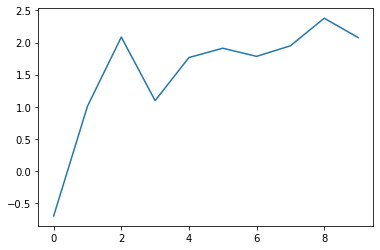

In [12]:
check_power(stationarity)

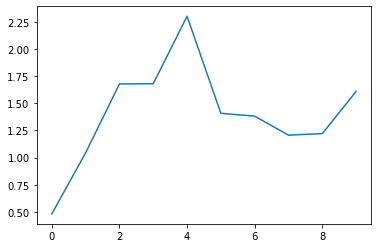

In [13]:
check_power(louvains)

In [2]:
g = Graph([Node(i) for i in range(1, 7)],
          [Edge(1, 6, 1),
           Edge(6, 1, 1),
           Edge(1, 2, 2),
           Edge(2, 1, 2),
           Edge(1, 3, 2),
           Edge(3, 1, 2),
           Edge(4, 6, 2),
           Edge(6, 4, 2),
           Edge(5, 6, 2),
           Edge(6, 5, 2),
           Edge(2, 3, 2),
           Edge(3, 2, 2),
           Edge(4, 5, 2),
           Edge(5, 4, 2),
           Edge(1, 1, 1),
           Edge(6, 6, 1)])
louvain(g)

1
6
FULL 0.0037256726408340796


[(1, 4), (2, 0), (3, 1), (4, 2), (5, 3), (6, 4)]

In [3]:
g = Graph([Node(i) for i in range(1, 5)],
          [Edge(1, 4, 1),
           Edge(1, 2, 1),
           Edge(2, 1, 1),
           Edge(2, 3, 1),
           Edge(3, 2, 1),
           Edge(1, 3, 1),
           Edge(3, 1, 1),
           Edge(1, 1, 1),
           Edge(2, 2, 1),
           Edge(3, 3, 1)
           ])
louvain(g)

1
4
FULL 0.018288389627213776
1
2
FULL 0.00871187922827097


[(1, 0), (2, 0), (3, 0), (4, 0)]

In [3]:
def X(y, x):

 try:
  x1 = x*np.log(x/y**2)
 except:
  x1 = 0
 try:
  x2 = (y-x)*np.log((y-x)/y/(1-y))
 except:
  x2 = 0

 return x1+x2
X(.66666667, .44444444) + X(0, 0) - X(.33333333, .11111111) - X(.33333333, .11111111)

2.980297365266398e-16

In [18]:
Graph([Node(i) for i in range(1, 3)], [Edge(1, 1, 3), Edge(1, 2, 2), Edge(2, 1, 2), Edge(2, 2, 1)], np.array([.667, .333])).objectivity()

0.00654507976147757

In [19]:
Graph([Node(1)], [Edge(1, 1, 8)], np.array([1.])).objectivity()

0.0

In [22]:
import community as community_louvain

In [32]:
import networkx as nx
from time import time

In [34]:
G = nx.complete_graph(2000)
start = time()
community_louvain.best_partition(G)
print(time() - start)

12.794581174850464
